# 0. Prelude

## 0.1. Install and Import Packages

In [101]:
# Install Required Packages
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Zip File Download and Extraction
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# Census Data Extraction
from census import Census
import pandas as pd

# GeoTif file extraction
import geopandas as gpd
from shapely import Point
import rioxarray

#Utilize .env file for api key(s)
from dotenv import dotenv_values
import os

import math

import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
import numpy as np 


## 0.2. Files and URL Register

In [3]:
# File locations for windows file system.

transit_routes_url = 'https://seshat.datasd.org/gis_transit_routes/transit_routes_datasd.zip'
transit_stops_url = 'https://seshat.datasd.org/gis_transit_stops/transit_stops_datasd.zip'
california_tracts_url = 'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_06_tract.zip'
us_counties_url = 'https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip'
HRPD_url = 'https://data.humdata.org/dataset/eec3a01f-5237-4896-8059-a6be193ca964/resource/58b480a3-afbd-4d1e-bd9f-5ef480bffb61/download/population_usa28_-120_2019-07-01.tif.zip'

transit_routes_file = ".\\Data\\transit_routes\\"
transit_stops_file = ".\\Data\\transit_stops\\"
california_tracts_file = ".\\Data\\california_tracts\\"
us_counties_file = ".\\Data\\us_counties\\"
HRPD_file = '.\\Data\\HRPD\\'

transit_stops_file_name = 'transit_stops_datasd.shp'
california_tracts_file_name = 'tl_2021_06_tract.shp'
us_counties_file_name = 'tl_2021_us_county.shp'
HRPD_file_name = 'population_usa28_-120_2019-07-01.tif'
HRPD_sd_shp_file_name = 'HRPD_sd.shp'

census_file_name = '.\\Data\\census_data.csv'

## Loading Census API Key from .env File

In [4]:
env_path = f"{os.getcwd()}\\.env"
config = dotenv_values(env_path)

census_api_key = config["census_api_key"]

#Census object to be used later
c = Census(
            census_api_key,
            year=2021)

## 0.3. Load Local Datasets

In [5]:
# Only need to run Data Collection and Transformation once.
# after that run this chunk to load the data, so you dont 
# have to redownload and reprocess the data.

# This code chunck will be Placed lower in the final verison.

county_df = gpd\
    .read_file(us_counties_file + us_counties_file_name)\
    .to_crs("EPSG:4326")
county_df = county_df.loc[county_df['NAME']== 'San Diego',]

tract_df = gpd\
    .read_file(california_tracts_file + california_tracts_file_name)\
    .to_crs("EPSG:4326")
tract_df = tract_df.loc[tract_df['COUNTYFP']== '073',]

#We are loading the HRPD file if the file already exists
try:
    HRPD_sd_df = gpd\
        .read_file(HRPD_file + HRPD_sd_shp_file_name)\
        .to_crs("EPSG:4326")
    print("Successfully loaded the HRPD file to a dataframe")
except Exception:
    print("There was an error loading the HRPD file")
    HRPD_sd_df = None
    pass

Successfully loaded the HRPD file to a dataframe


# 1. Data Collection and Transformation

## 1.1. Download & Unzip shape and raster files.

In [7]:
def download_unzip(file_url,file_location):
    with urlopen(file_url) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(file_location)

download_unzip(transit_routes_url,transit_routes_file)
download_unzip(transit_stops_url,transit_stops_file)
download_unzip(california_tracts_url,california_tracts_file)
download_unzip(us_counties_url,us_counties_file)
download_unzip(HRPD_url,HRPD_file)

## 1.2. Create Census Data Table

In [8]:
name_list = ['Total'
             , 'Less than 5 mins'
             , '5 to 10 Mins'
             , '10 to 15 Mins'
             , '15 to 20 Mins'
             , '20 to 25 Mins'
             , '25 to 30 Mins'
             , '30 to 35 Mins'
             , '35 to 40 Mins'
             , '40 to 45 Mins'
             , '45 to 60 Mins'
             , '60 to 90 Mins'
             , 'More than 90 Mins'
             , 'Total Population'
             ]

key_list = ['B08303_0'+str(i).zfill(2)+'E' for i in range(1, len(name_list))]
key_list += [
    'B01003_001E',
    

]
key_list

['B08303_001E',
 'B08303_002E',
 'B08303_003E',
 'B08303_004E',
 'B08303_005E',
 'B08303_006E',
 'B08303_007E',
 'B08303_008E',
 'B08303_009E',
 'B08303_010E',
 'B08303_011E',
 'B08303_012E',
 'B08303_013E',
 'B01003_001E']

In [9]:
#See https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields
socio_eco_census = c.acs5.state_county_tract(
    
    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields = key_list       # All Estimate Fields in Coummute survery table., Population
)

In [10]:
census_df = pd.DataFrame(socio_eco_census)

### 1.2.1. Rename Columns to appropriate title

In [11]:
column_rename = {key_list[i]: name_list[i] for i in range(0,len(key_list))}

census_df = census_df.rename(columns=column_rename)

census_df

Total  Less than 5 mins  5 to 10 Mins  10 to 15 Mins  15 to 20 Mins  \
0     982.0               7.0          68.0          152.0          261.0   
1     935.0              21.0         166.0          161.0          184.0   
2    2184.0              23.0         118.0          408.0          553.0   
3    1376.0              29.0          23.0          352.0          245.0   
4    1860.0              36.0         397.0          258.0          337.0   
..      ...               ...           ...            ...            ...   
732  2030.0              40.0         210.0          372.0          304.0   
733  2040.0               0.0         214.0          181.0          578.0   
734   708.0               0.0         161.0          137.0           52.0   
735  1950.0               0.0         163.0          313.0          446.0   
736     0.0               0.0           0.0            0.0            0.0   

     20 to 25 Mins  25 to 30 Mins  30 to 35 Mins  35 to 40 Mins  \
0            152.0           75.0          158.0            0.0   
1            122.0           10.0          117.0           19.0   
2            444.0           98.0          261.0            0.0   
3            224.0           69.0          150.0           49.0   
4            226.0           55.0          342.0           57.0   
..             ...            ...            ...            ...   
732          273.0          146.0          307.0           64.0   
733          257.0          131.0          262.0           23.0   
734           48.0           10.0           89.0           10.0   
735          188.0           47.0          231.0          127.0   
736            0.0            0.0            0.0            0.0   

     40 to 45 Mins  45 to 60 Mins  60 to 90 Mins  More than 90 Mins  \
0             44.0           60.0            0.0                5.0   
1             52.0           74.0            0.0                9.0   
2             21.0          136.0           88.0               34.0   
3             12.0          131.0           51.0               41.0   
4             21.0           94.0            9.0               28.0   
..             ...            ...            ...                ...   
732           65.0          130.0           92.0               27.0   
733           60.0           35.0           90.0              209.0   
734           20.0           98.0           77.0                6.0   
735           16.0          243.0          100.0               76.0   
736            0.0            0.0            0.0                0.0   

     Total Population state county   tract  
0              2956.0    06    073  000100  
1              2309.0    06    073  000201  
2              4116.0    06    073  000202  
3              2250.0    06    073  000301  
4              3042.0    06    073  000302  
..                ...   ...    ...     ...  
732            3600.0    06    073  021900  
733            4504.0    06    073  022000  
734            2280.0    06    073  022101  
735            8017.0    06    073  022102  
736               0.0    06    073  990100  

[737 rows x 17 columns]

### 1.2.2. Remove trivial columns and rows.

In [12]:
census_df = census_df.drop(columns=['state','county'], index=[736])

### 1.2.3. Add Mean Time Column

In [13]:
commute_mean_time = [0 for x in range(736)]
for i in range(1,10):
    commute_mean_time = commute_mean_time + \
        census_df[name_list[i]]*(2.5+(i-1)*5)

commute_mean_time = commute_mean_time +  census_df[name_list[10]]*52.75
commute_mean_time = commute_mean_time +  census_df[name_list[11]]*75
commute_mean_time = commute_mean_time/census_df['Total']

# Ignoring 90 mins for now.
# commute_mean_time.mean()

census_df['Mean Time'] = commute_mean_time

### 1.2.4. Save Dataframe to CSV file

In [14]:
census_df.to_csv(census_file_name,index=False)
census_df

Total  Less than 5 mins  5 to 10 Mins  10 to 15 Mins  15 to 20 Mins  \
0     982.0               7.0          68.0          152.0          261.0   
1     935.0              21.0         166.0          161.0          184.0   
2    2184.0              23.0         118.0          408.0          553.0   
3    1376.0              29.0          23.0          352.0          245.0   
4    1860.0              36.0         397.0          258.0          337.0   
..      ...               ...           ...            ...            ...   
731   658.0               3.0          48.0           71.0          202.0   
732  2030.0              40.0         210.0          372.0          304.0   
733  2040.0               0.0         214.0          181.0          578.0   
734   708.0               0.0         161.0          137.0           52.0   
735  1950.0               0.0         163.0          313.0          446.0   

     20 to 25 Mins  25 to 30 Mins  30 to 35 Mins  35 to 40 Mins  \
0            152.0           75.0          158.0            0.0   
1            122.0           10.0          117.0           19.0   
2            444.0           98.0          261.0            0.0   
3            224.0           69.0          150.0           49.0   
4            226.0           55.0          342.0           57.0   
..             ...            ...            ...            ...   
731          150.0           35.0           29.0           43.0   
732          273.0          146.0          307.0           64.0   
733          257.0          131.0          262.0           23.0   
734           48.0           10.0           89.0           10.0   
735          188.0           47.0          231.0          127.0   

     40 to 45 Mins  45 to 60 Mins  60 to 90 Mins  More than 90 Mins  \
0             44.0           60.0            0.0                5.0   
1             52.0           74.0            0.0                9.0   
2             21.0          136.0           88.0               34.0   
3             12.0          131.0           51.0               41.0   
4             21.0           94.0            9.0               28.0   
..             ...            ...            ...                ...   
731            0.0           19.0           49.0                9.0   
732           65.0          130.0           92.0               27.0   
733           60.0           35.0           90.0              209.0   
734           20.0           98.0           77.0                6.0   
735           16.0          243.0          100.0               76.0   

     Total Population   tract  Mean Time  
0              2956.0  000100  23.062627  
1              2309.0  000201  21.581283  
2              4116.0  000202  23.605311  
3              2250.0  000301  24.584121  
4              3042.0  000302  20.734409  
..                ...     ...        ...  
731            2017.0  021800  24.862842  
732            3600.0  021900  24.975369  
733            4504.0  022000  21.515319  
734            2280.0  022101  28.597458  
735            8017.0  022102  26.528590  

[736 rows x 16 columns]

## 1.3. Convert HRPD Raster Data to Shapefile

In [18]:
#We are creating the HRPD df and file if it wasn't loaded successfully earlier
if HRPD_sd_df is None:
    san_deigo_polygon = county_df.loc[539,'geometry']

    # Takes some Time (35sec on desktop)
    HRPD_tif = rioxarray.open_rasterio(HRPD_file + HRPD_file_name, cache = False)
    # If an OOM (or other) error occurs we are utilizing the from_disk option
    try:
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = False)
    except:
        print("Utilizing the rio.clip from_disk flag")
        HRPD_sd_tif = HRPD_tif.rio.clip([san_deigo_polygon], from_disk = True)
    HRPD_tif = HRPD_sd_tif.rio.reproject("EPSG:4326", cache = False)
    # Takes some Time (10sec on desktop)
    HRPD_sd_df = HRPD_sd_tif[0].to_dataframe('Population').dropna()
    HRPD_sd_df['geometry'] = [Point(index[1],index[0]) for index,row in HRPD_sd_df.iterrows()]
    HRPD_sd_df = gpd.GeoDataFrame(HRPD_sd_df['Population'],
                                geometry = HRPD_sd_df['geometry'])\
                                    .reset_index(drop=True)
    # Takes some Time (25sec on desktop)
    HRPD_sd_df.to_file(HRPD_file + HRPD_sd_shp_file_name, 
                    index=False,
                    crs='EPSG:4326', windowed = True)


In [6]:
HRPD_sd_df

Population                     geometry
0         0.134667  POINT (-117.37083 33.49083)
1         0.908454  POINT (-117.40111 33.48444)
2         0.908454  POINT (-117.40111 33.48389)
3         0.908454  POINT (-117.40000 33.48361)
4         0.908454  POINT (-117.37444 33.48111)
...            ...                          ...
797661    0.074160  POINT (-117.11417 32.53556)
797662    0.074160  POINT (-117.11389 32.53556)
797663    0.074160  POINT (-117.11889 32.53528)
797664    0.074160  POINT (-117.11694 32.53528)
797665    0.074160  POINT (-117.11667 32.53528)

[797666 rows x 2 columns]

## 1.4. Create other paramerters by processing data

### 1.4.1. Create Pop Centers, tract Pop and Distance from Hub

In [7]:
def pop_center(pop_table):
    x = 0
    y = 0
    pop_total = 0
    for index,row in pop_table.iterrows():
        x += row['geometry'].x*row['Population']
        y += row['geometry'].y*row['Population']
        pop_total += row['Population']

    return Point(x/pop_total ,y/pop_total)

tract_df['tract'] = pd.to_numeric(tract_df['TRACTCE'])
tract_df = tract_df[tract_df['tract'] != 990100]

# Takes some Time (50sec on desktop)
pop_center_list = [pop_center(HRPD_sd_df.clip(row['geometry'])) for index, row in tract_df.iterrows()]


In [28]:
#pop_center_list = gpd.GeoSeries(pop_center_list).set_crs("EPSG:4326")

In [8]:
def point_distance(point_1,point_2):
    return math.sqrt((point_1.x-point_2.x)**2 + (point_1.y-point_2.y)**2)

commute_hub_1 = tract_df.loc[tract_df['tract'] == 5403,'geometry'].centroid

pop_distance = [point_distance(pop_center,commute_hub_1 ) for pop_center in pop_center_list]

C:\Users\Kabir\AppData\Local\Temp\ipykernel_31900\4055002358.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  commute_hub_1 = tract_df.loc[tract_df['tract'] == 5403,'geometry'].centroid
C:\Users\Kabir\AppData\Local\Temp\ipykernel_31900\4055002358.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.sqrt((point_1.x-point_2.x)**2 + (point_1.y-point_2.y)**2)


In [9]:
tract_df['distance from commute hub 1'] = pop_distance

### 1.4.2. Create Stops and Route Length in Tracts

In [22]:
transit_stops_df = gpd.read_file(transit_stops_file + transit_stops_file_name).to_crs("EPSG:4326")
stop_count = []
# stop_count_no_buffer = []
for index,row in tract_df.iterrows():

    tract_polygon = row['geometry']

    overlapping_stops = transit_stops_df[transit_stops_df.within(tract_polygon.buffer(0.0001, join_style=2))]
    # overlapping_stops_no_buff = transit_stops_df[transit_stops_df.within(tract_polygon)]

    total_stop_count = len(overlapping_stops["stop_uid"].unique())
    # total_stop_count_no_buff = len(overlapping_stops_no_buff["stop_uid"].unique())

    stop_count.append(total_stop_count)
    # stop_count_no_buffer.append(total_stop_count_no_buff)

tract_df['stop_count']  = stop_count

In [94]:
transit_routes_df = gpd.read_file(transit_routes_file + 'transit_routes_datasd.shp').to_crs("EPSG:4326")

#Adding area in meters to tract df
tract_df["tract_area_m"] = tract_df.to_crs(crs = 3857).area

# Remember to Buffer the tract polygons, so the correctly include the stops around them
for index, row in tract_df.iterrows():

    
    tract_polygon = row['geometry']

    overlapping_routes = transit_routes_df.overlay(tract_polygon.buffer(0.0001, join_style=2))

    #We are calculating the total length of meters of the routes and counting the # of overlapping routes
    #3857 for meters
    total_route_meters = sum(overlapping_routes.to_crs(crs = 3857).length)
    total_route_count = len(overlapping_routes["route_id"].unique())
    
    #We are assigning this values to our tract df copy
    tract_df.loc[tract_df_copy["TRACTCE"].eq(tract),"total_route_length_m"] = total_route_meters
    tract_df.loc[tract_df_copy["TRACTCE"].eq(tract),"total_route_count"] = total_route_count

#We are creating a ratio of the total route meters to area
tract_df["total_route_length_to_area_ratio"] = tract_df["total_route_length_m"] / \
        tract_df["tract_area_m"]

tract_df

STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  \
1627      06      073  007702  06073007702   77.02   Census Tract 77.02   
1628      06      073  020308  06073020308  203.08  Census Tract 203.08   
1654      06      073  017801  06073017801  178.01  Census Tract 178.01   
1670      06      073  012303  06073012303  123.03  Census Tract 123.03   
1671      06      073  004200  06073004200      42      Census Tract 42   
...      ...      ...     ...          ...     ...                  ...   
9039      06      073  000400  06073000400       4       Census Tract 4   
9040      06      073  000500  06073000500       5       Census Tract 5   
9041      06      073  000600  06073000600       6       Census Tract 6   
9051      06      073  003103  06073003103   31.03   Census Tract 31.03   
9052      06      073  003105  06073003105   31.05   Census Tract 31.05   

      MTFCC FUNCSTAT    ALAND  AWATER  ...      INTPTLON  \
1627  G5020        S   618401       0  ...  -117.2350654   
1628  G5020        S  1211945       0  ...  -117.0979771   
1654  G5020        S  4345848  116020  ...  -117.3403004   
1670  G5020        S  1537489   28342  ...  -117.0724250   
1671  G5020        S  2493055       0  ...  -117.1194471   
...     ...      ...      ...     ...  ...           ...   
9039  G5020        S  1177454       0  ...  -117.1630702   
9040  G5020        S  1108651       0  ...  -117.1519499   
9041  G5020        S   932839       0  ...  -117.1518411   
9051  G5020        S  2039646       0  ...  -117.0441008   
9052  G5020        S  1210504       0  ...  -117.0295699   

                                               geometry  tract  \
1627  POLYGON ((-117.23910 32.79396, -117.23873 32.7...   7702   
1628  POLYGON ((-117.10405 33.14203, -117.10390 33.1...  20308   
1654  POLYGON ((-117.34962 33.17620, -117.34904 33.1...  17801   
1670  POLYGON ((-117.08635 32.65061, -117.08626 32.6...  12303   
1671  POLYGON ((-117.12547 32.72395, -117.12547 32.7...   4200   
...                                                 ...    ...   
9039  POLYGON ((-117.17087 32.75865, -117.17019 32.7...    400   
9040  POLYGON ((-117.16151 32.75890, -117.16149 32.7...    500   
9041  POLYGON ((-117.16083 32.75827, -117.16077 32.7...    600   
9051  POLYGON ((-117.05533 32.70560, -117.05532 32.7...   3103   
9052  POLYGON ((-117.03742 32.71241, -117.03690 32.7...   3105   

      total_stop_count  tract_area_m  total_route_length_m  total_route_count  \
1627               7.0  8.774833e+05          15303.884561                1.0   
1628              10.0  1.733142e+06           2907.316866                3.0   
1654              29.0  6.385392e+06          43758.929507                5.0   
1670               5.0  2.214994e+06           6178.194758                2.0   
1671               0.0  3.532758e+06          14889.790771                2.0   
...                ...           ...                   ...                ...   
9039              13.0  1.669388e+06          29097.032369                9.0   
9040               3.0  1.572093e+06           3790.767847                6.0   
9041              10.0  1.322567e+06          56682.792020                8.0   
9051              17.0  2.888829e+06          26931.408723                4.0   
9052              21.0  1.714623e+06          21654.216787                1.0   

      total_route_length_to_area_ratio  \
1627                          0.017441   
1628                          0.001677   
1654                          0.006853   
1670                          0.002789   
1671                          0.004215   
...                                ...   
9039                          0.017430   
9040                          0.002411   
9041                          0.042858   
9051                          0.009323   
9052                          0.012629   

                                  population_center  \
1627  POINT (-117.11356597993698 32.88412768128524)   
16

# 2. Regression Models

In [44]:
tract_df = tract_df.drop(columns=['STATEFP','COUNTYFP','TRACTCE','GEOID','NAME','NAMELSAD','MTFCC','FUNCSTAT','ALAND','AWATER','INTPTLAT','INTPTLON','geometry'])

KeyError: "['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'] not found in axis"

In [56]:
tract_df = tract_df.sort_values(by=['tract']).reset_index(drop=True)
tract_df

tract  total_stop_count  tract_area_m  total_route_length_m  \
0      100               7.0  2.178075e+06           8894.144837   
1      201               7.0  1.225291e+06           4101.131348   
2      202              11.0  1.851316e+06          23210.956041   
3      301               7.0  5.695554e+05           8246.988806   
4      302              10.0  7.044608e+05          39698.719570   
..     ...               ...           ...                   ...   
731  21800               6.0  2.029660e+06          11843.975483   
732  21900              34.0  1.344498e+07         131656.388768   
733  22000               8.0  1.033846e+06          14260.865121   
734  22101              52.0  1.790678e+07          46671.422520   
735  22102              19.0  8.772776e+06           9156.211832   

     total_route_count  total_route_length_to_area_ratio  \
0                  4.0                          0.004083   
1                  8.0                          0.003347   
2                 14.0                          0.012538   
3                 14.0                          0.014480   
4                 42.0                          0.056353   
..                 ...                               ...   
731               12.0                          0.005835   
732               70.0                          0.009792   
733               18.0                          0.013794   
734               10.0                          0.002606   
735                4.0                          0.001044   

     distance from commute hub 1  
0                       0.049083  
1                       0.045199  
2                       0.038100  
3                       0.036690  
4                       0.035475  
..                           ...  
731                     0.029002  
732                     0.061919  
733                     0.082171  
734                     0.454105  
735                     0.422295  

[736 rows x 7 columns]

In [57]:
census_df['tract'] = pd.to_numeric(census_df['tract'])
census_df = census_df.sort_values(by=['tract']).reset_index(drop=True)
census_df

Total  Less than 5 mins  5 to 10 Mins  10 to 15 Mins  15 to 20 Mins  \
0     982.0               7.0          68.0          152.0          261.0   
1     935.0              21.0         166.0          161.0          184.0   
2    2184.0              23.0         118.0          408.0          553.0   
3    1376.0              29.0          23.0          352.0          245.0   
4    1860.0              36.0         397.0          258.0          337.0   
..      ...               ...           ...            ...            ...   
731   658.0               3.0          48.0           71.0          202.0   
732  2030.0              40.0         210.0          372.0          304.0   
733  2040.0               0.0         214.0          181.0          578.0   
734   708.0               0.0         161.0          137.0           52.0   
735  1950.0               0.0         163.0          313.0          446.0   

     20 to 25 Mins  25 to 30 Mins  30 to 35 Mins  35 to 40 Mins  \
0            152.0           75.0          158.0            0.0   
1            122.0           10.0          117.0           19.0   
2            444.0           98.0          261.0            0.0   
3            224.0           69.0          150.0           49.0   
4            226.0           55.0          342.0           57.0   
..             ...            ...            ...            ...   
731          150.0           35.0           29.0           43.0   
732          273.0          146.0          307.0           64.0   
733          257.0          131.0          262.0           23.0   
734           48.0           10.0           89.0           10.0   
735          188.0           47.0          231.0          127.0   

     40 to 45 Mins  45 to 60 Mins  60 to 90 Mins  More than 90 Mins  \
0             44.0           60.0            0.0                5.0   
1             52.0           74.0            0.0                9.0   
2             21.0          136.0           88.0               34.0   
3             12.0          131.0           51.0               41.0   
4             21.0           94.0            9.0               28.0   
..             ...            ...            ...                ...   
731            0.0           19.0           49.0                9.0   
732           65.0          130.0           92.0               27.0   
733           60.0           35.0           90.0              209.0   
734           20.0           98.0           77.0                6.0   
735           16.0          243.0          100.0               76.0   

     Total Population  tract  Mean Time  
0              2956.0    100  23.062627  
1              2309.0    201  21.581283  
2              4116.0    202  23.605311  
3              2250.0    301  24.584121  
4              3042.0    302  20.734409  
..                ...    ...        ...  
731            2017.0  21800  24.862842  
732            3600.0  21900  24.975369  
733            4504.0  22000  21.515319  
734            2280.0  22101  28.597458  
735            8017.0  22102  26.528590  

[736 rows x 16 columns]

In [58]:
tract_df['population'] = census_df['Total Population']

In [87]:
census_df[y.isna()]
census_df = census_df.drop([269,280])
tract_df = tract_df.drop([269,280])

In [90]:
x = tract_df.iloc[:,1:]
y = census_df['Mean Time']

train_dmatrix = xg.DMatrix(data = x, label = y) 

param = {"booster":"gblinear", "objective":"reg:linear"} 

xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10) 
pred = xgb_r.predict(train_dmatrix) 
  
# RMSE Computation 
rmse = np.sqrt(MSE(y, pred)) 
print("RMSE : % f" %(rmse))

RMSE :  3.765061


c:\Users\Kabir\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


# 3. Scratch Code for Testing

In [ ]:
#You can request an API key from https://api.census.gov/data/key_signup.html
API_KEY = '9e94761d2b2fb214be8b88bdaeccc47b8edded35'

c = Census(API_KEY,
           year=2021)

#See https://api.census.gov/data/2021/acs/acs5/groups/B08303.html for available fields
population_census = c.acs5.state_county_tract(
    
    state_fips = "06",      # California
    county_fips = "073",    # San Diego
    tract = "*",            # All tracts
    fields = 'B01003_001E', # Total Population
)
population_df = pd.DataFrame(population_census)
population_df = population_df.drop(columns=['state','county'], index=[736])
population_df = population_df.rename(columns={'B01003_001E': 'Total Population'})
population_df

In [25]:
population_df['Total Population'].sum()

3296317.0

In [26]:
HRPD_sd_df['Population'].sum()

2782294.505288508

In [200]:
def pop_center(pop_table):
    x = 0
    y = 0
    pop_total = 0
    for index,row in pop_table.iterrows():
        x += row['geometry'].x*row['Population']
        y += row['geometry'].y*row['Population']
        pop_total += row['Population']

    return Point(x/pop_total ,y/pop_total)

tract_df['tract'] = pd.to_numeric(tract_df['TRACTCE'])
tract_df = tract_df[tract_df['tract'] != 990100]

# Takes some Time (50sec on desktop)
pop_center_list = gpd.GeoSeries([pop_center(HRPD_sd_df.clip(row['geometry'])) for index, row in tract_df.iterrows()])

In [ ]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(16,12))
tract_df.boundary.plot(ax=ax,linewidth=0.2)
HRPD_sd_df.plot(column='Population',
                           ax=ax,
                           markersize=0.01,
                           cmap='YlGnBu',
                           legend=True,
                           norm=colors.LogNorm(0.0029,520)
                           )
transit_stops_df.plot(ax=ax,color='black',markersize=0.1)
gpd.GeoSeries(pop_center_list).plot(ax=ax, markersize=1, color='red')
plt.title("HRPD - San Diego, with pop centers",
          fontsize=25)

## Testing Stop Metrics

C:\Users\smith\AppData\Local\Temp\ipykernel_29024\587387984.py:24: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  tract_df.loc[tract_df["TRACTCE"].eq("021304")].plot(ax = ax, alpha = 0.5, column = "total_stop_count", color = "white")


Text(0.5, 1.0, 'MTS Stops in SD County with Census Tracts Colored by Total Stop Count')

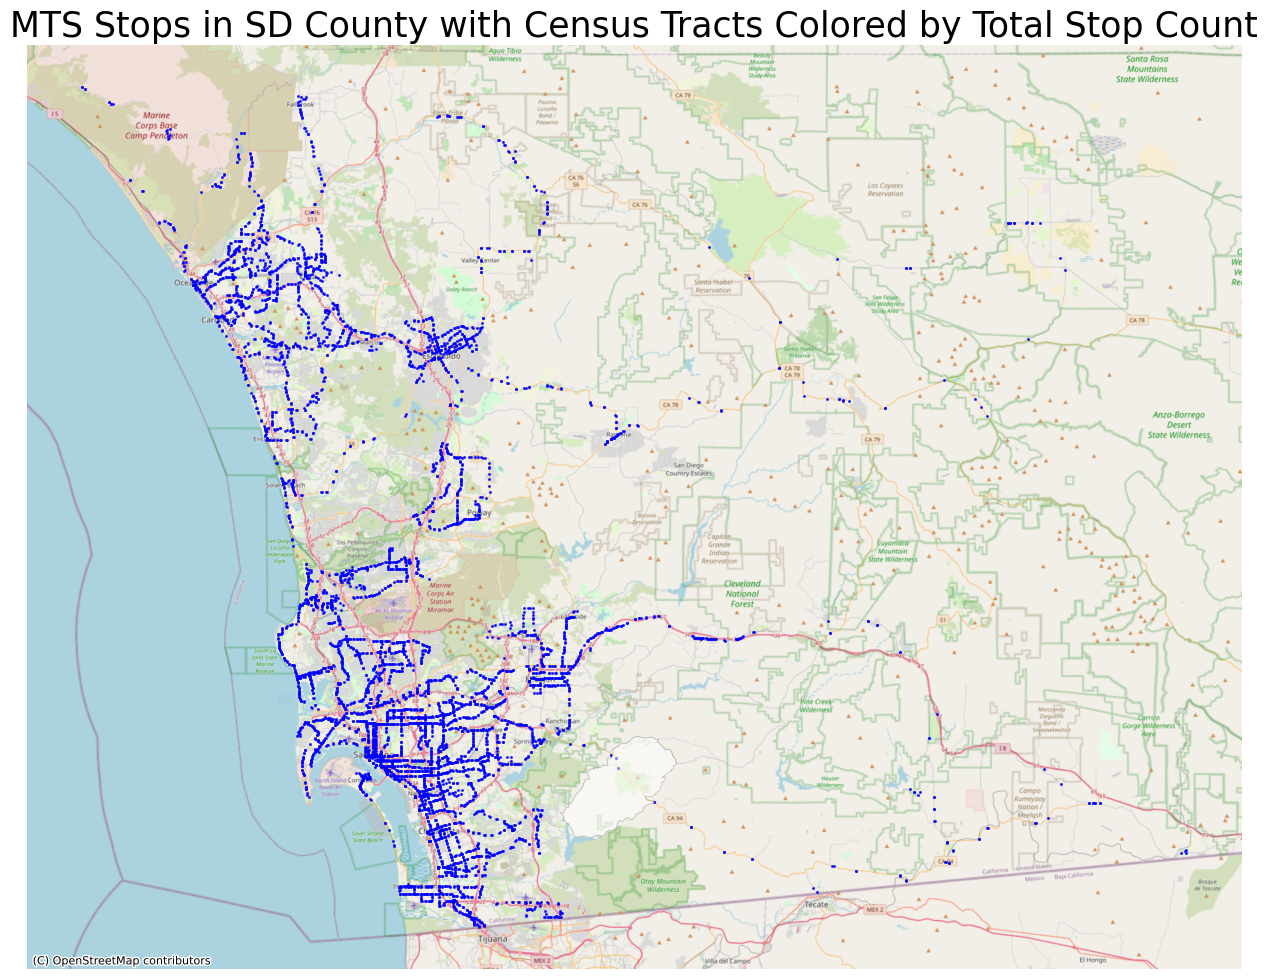

In [95]:
#Testing total stop counts

import contextily as cx

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (16, 12)
)

#Plotting routes
transit_stops_df.plot(ax = ax, linewidth = 0.2, alpha = 1, color = "blue", markersize = 3)

#Plotting an OSM basemap
cx.add_basemap(
    ax = ax,
    source = cx.providers.OpenStreetMap.Mapnik,
    zoom = 11,
    crs = transit_stops_df.crs,
)

#Plotting the boundaries of the census tracts
tract_df.loc[tract_df["TRACTCE"].eq("021304")].boundary.plot(ax = ax, alpha = 1, color = "black", linewidth = 0.1)
tract_df.loc[tract_df["TRACTCE"].eq("021304")].plot(ax = ax, alpha = 0.5, column = "total_stop_count", color = "white")

ax.axis("off")
plt.title("MTS Stops in SD County with Census Tracts Colored by Total Stop Count", fontsize = 25)

## Testing Routes Length Metrics

Text(0.5, 1.0, 'MTS Routes in SD County with Census Tracts Colored by Total Route Length/Census Tract Area')

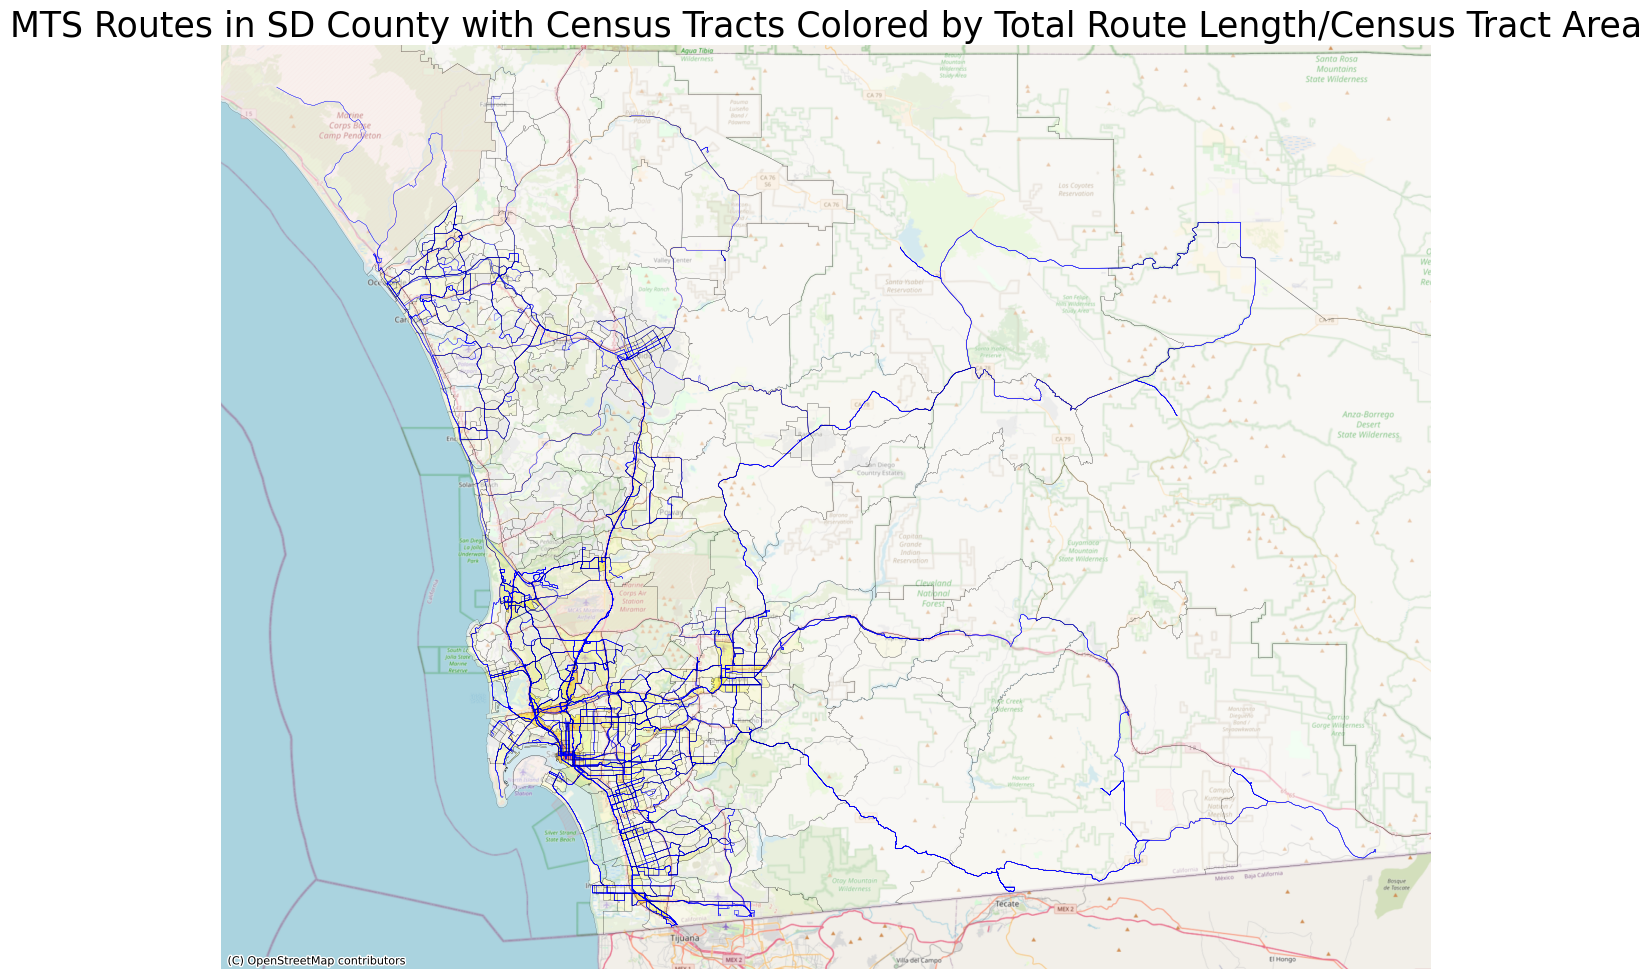

In [100]:
#Testing total route length/census tract area

import contextily as cx

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (16, 12)
)

#Plotting routes
transit_routes_df.plot(ax = ax, linewidth = 0.2, alpha = 1, color = "blue")

#Plotting an OSM basemap
cx.add_basemap(
    ax = ax,
    source = cx.providers.OpenStreetMap.Mapnik,
    zoom = 11,
    crs = transit_routes_df.crs,
)

#Plotting the boundaries of the census tracts
tract_df.boundary.plot(ax = ax, alpha = 1, color = "black", linewidth = 0.1)
tract_df.plot(ax = ax, alpha = 0.5, column = "total_route_length_to_area_ratio", cmap = "hot_r")

ax.axis("off")
plt.title("MTS Routes in SD County with Census Tracts Colored by Total Route Length/Census Tract Area", fontsize = 25)

Text(0.5, 1.0, 'MTS Routes in SD County with Census Tracts Colored by Total Route Length')

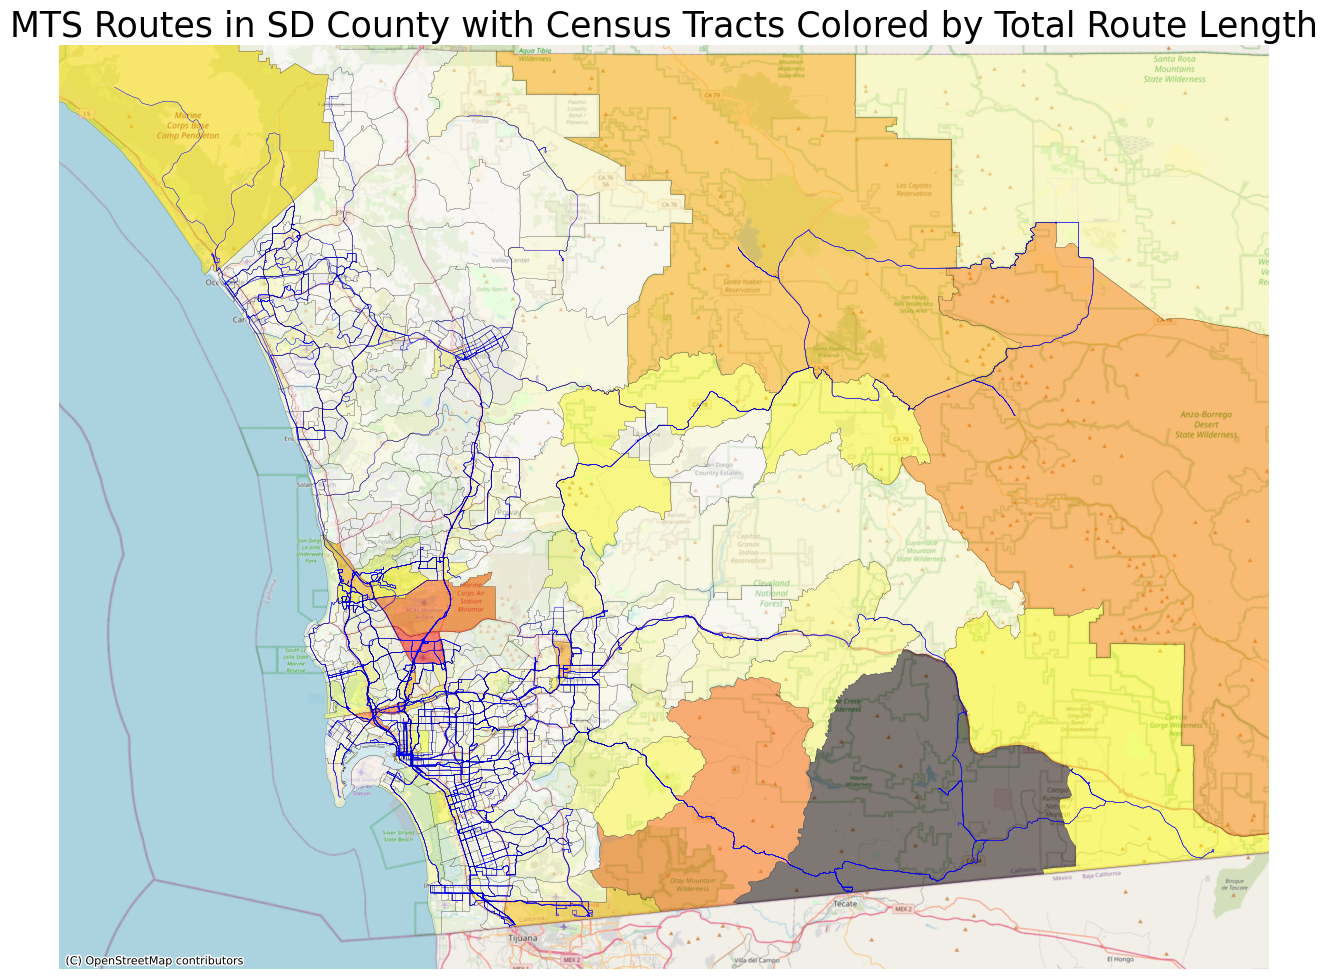

In [101]:
#Testing total route length

import contextily as cx

fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (16, 12)
)

#Plotting routes
transit_routes_df.plot(ax = ax, linewidth = 0.2, alpha = 1, color = "blue")

#Plotting an OSM basemap
cx.add_basemap(
    ax = ax,
    source = cx.providers.OpenStreetMap.Mapnik,
    zoom = 11,
    crs = transit_routes_df.crs,
)

#Plotting the boundaries of the census tracts
tract_df.boundary.plot(ax = ax, alpha = 1, color = "black", linewidth = 0.1)
tract_df.plot(ax = ax, alpha = 0.5, column = "total_route_length_m", cmap = "hot_r")

ax.axis("off")
plt.title("MTS Routes in SD County with Census Tracts Colored by Total Route Length", fontsize = 25)